## Обратная связь


### Добавить к методам и классам doc-string

✅ Прошлый семинар перезалил с комментами

✅ Текущий семинар обновил, добавил комменты

✅ В чек-лист перед семинаром добавил напоминалочку


### GPU vs CPU


#### CPU:

**Цель**: вычисления общего назначения

* Кол-во ядер: ~128
* Мощность ядер: 3.5 GHz


#### GPU:

**Цель**: узкоспециализированные вычисления, с большой степенью **распараллеливания**

* Кол-во ядер: ~7k
* Мощность ядер: ~1 GHz


#### Полезные материалы:

* [YouTube видео](https://www.youtube.com/watch?v=Axd50ew4pco), в котором объясняется разница
* [WebGPU Puzzles](https://gpupuzzles.answer.ai/intro)
* [Nvidia Cuda Programming Guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/)


PS Еще про низкоуровневое устройство `GPU` я планирую запилить домашку и семинар ближе к концу курса.

# Recap

### 🧮 Мотивация

Нейронная сеть -- большая формула с коэффициентами (весами).

Нейросети сами выучивают признаки, которые важны для предикта. Не надо заниматься фича-инженирингом.

### 📉 Градиенты

Для вычисления градиентов весов мы используем алгоритм обратного распространения ошибки. Когда градиенты вычислены, оптимизатор делает шаг оптимимзации.

### 📏 Нелинейность

Если из нейросети убрать все нелинейные преобразования, она выродится в линейную регрессию. `ReLU` - неплохой бейзлайн для ф-и активации.

### 🔮 Инициализация

Веса нейросети по умолчанию инициализируются рандомно. Но можно изменять алгоритмы инициализации весов и это может существенно.

### 🔎 Метрики

TL; DR:
- тренировочные метрики нужно записывать без сглаживания с каждого батча
- валидационные собирать за всю валидацию и рисовать одной точкой


**Особенности TensorBoard**:

- При отображении прореживает точки по global_step, если точек очень много
- Чтобы рисовать на одном графике надо писать в разные папки (завести отдельные train_ и val_writer)
- Хорошей идеей будет создание новой директории с логами для нового эксперимента (можно завязаться, например, на текущую дату+время, чтобы не было коллизий для новых запусков трейнеров)

-----



# Оптимизация нейросетей. Дропаут.


# Задачи

Оптимизация начинается с лосса. Лосс обычно выбирают в зависимости от задачи.

### Делаем регрессию

**Mean Squared Error** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss))

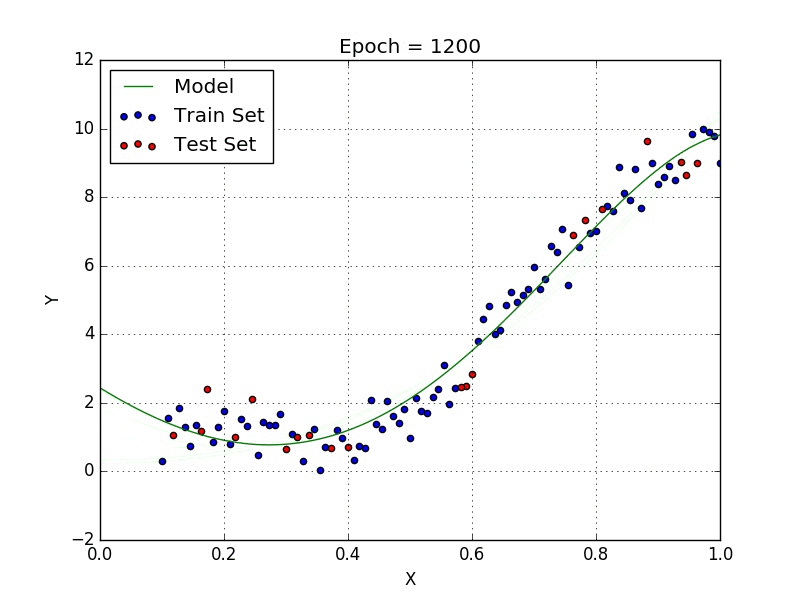

In [1]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.randn(3, 2)

output = loss.forward(input, target)
output

tensor(3.2744, grad_fn=<MseLossBackward0>)


### Делаем классификацию:

**Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


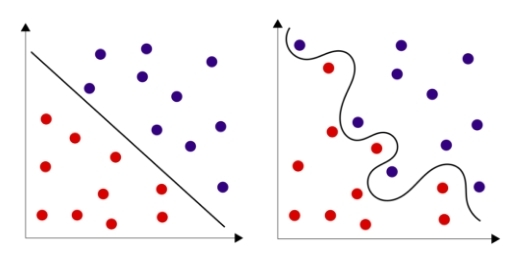

In [2]:
# Example of target with class indices

import torch.nn as nn

loss = nn.CrossEntropyLoss() # nn.Softmax + nn.NLLoss
input = torch.randn(3, 5, requires_grad=True) # [ batch_size, class_probability ]

# [ batch_size ] -- метки каждого класса, каждая метка -- это число от [0 до 5)
target = torch.empty(3, dtype=torch.long).random_(5)

output = loss(input, target)
output

tensor(2.1240, grad_fn=<NllLossBackward0>)

### Делаем теггирование:

**Binary Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html))


Примером может быть задача тэгорования треков: один трек может именть несколько жанров: `pop`, `rock`, `jazz`, `russian`, `1980s`...

In [3]:
sigmoid = nn.Sigmoid()
loss = nn.BCELoss()

input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(sigmoid(input), target)
output

tensor(0.4758, grad_fn=<BinaryCrossEntropyBackward0>)

# Оптимизация

### Моделька

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class MLP(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        self.inner = nn.Sequential(nn.Linear(2, 16), # заведомо довольно большая модель, чтобы очевиднее был эффект переобучения и дропаута
                                   nn.ReLU(),
                                   nn.Linear(16, 16),
                                   nn.ReLU(),
                                   nn.Linear(16, 1))

    def forward(self, x):
        return self.inner(x)


### model.parameters()


In [6]:
model = MLP()
params = model.parameters()
params_list = list(params)

In [7]:
params_list

[Parameter containing:
 tensor([[ 0.5579,  0.1999],
         [-0.6207, -0.1212],
         [-0.4124, -0.3105],
         [-0.6183, -0.4063],
         [ 0.7021, -0.0467],
         [-0.3023, -0.1671],
         [-0.1460,  0.1130],
         [ 0.3387, -0.3138],
         [ 0.1542,  0.0352],
         [ 0.6232, -0.3368],
         [ 0.0389,  0.2945],
         [-0.6006, -0.6234],
         [-0.1450,  0.0830],
         [ 0.6259,  0.1472],
         [ 0.2944,  0.0246],
         [ 0.5616,  0.6123]], requires_grad=True),
 Parameter containing:
 tensor([-0.1837,  0.6429, -0.6334, -0.1039, -0.7030,  0.4447, -0.1738,  0.2925,
          0.1803,  0.2542,  0.2931,  0.0306,  0.5849, -0.7010, -0.2784,  0.6185],
        requires_grad=True),
 Parameter containing:
 tensor([[-1.9042e-01, -1.8302e-01, -1.8236e-01, -1.4390e-01,  1.8139e-02,
           1.5154e-02,  3.6826e-02, -7.7484e-02, -2.2178e-02, -2.2270e-01,
           1.1205e-02, -1.0457e-01,  6.0579e-02,  2.1917e-01,  1.4040e-02,
          -1.1385e-01],
    

In [8]:
# В этом методе градиенты всегда будут рандомными!
# В реальности данные и метки должны браться из датасета, а не из рандома
def example_compute_random_gradients(model):
    batch_size = 3
    model_input = torch.rand([batch_size, 2])
    target_batch_values = torch.randint(0, 1, [batch_size]) * 2 - 1 # -1/1 target values

    model_prediction = model.forward(model_input)

    loss = F.relu(1 - target_batch_values * model_prediction).mean()

    model.zero_grad()
    loss.backward()  # compute loss

### Hands optimizer


In [9]:
model = MLP()
example_compute_random_gradients(model)

learning_rate = 0.01

# optimization step
for p in model.parameters():
    p.data = p.data - learning_rate * p.grad

### Pytorch Optimizer

In [10]:
from torch.optim import SGD, Adam

In [11]:
model = MLP()
sgd_optimizer = SGD(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

sgd_optimizer.step() # итериуется по сохраненным на этапе инициализации параметрам и обновляет параметры

In [12]:
## Другие оптимизаторы
from torch.optim import Adam

adam_optimizer = Adam(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

adam_optimizer.step()

Можем вспомнить, что оптимизатор хранит статиситики по градиентам параметров!

Для хранения этих статистик тоже используется память на видео-карте.

In [13]:
adam_optimizer.state_dict()

{'state': {0: {'step': tensor(1.),
   'exp_avg': tensor([[-0.0017, -0.0018],
           [-0.0025, -0.0032],
           [ 0.0000,  0.0000],
           [ 0.0000,  0.0000],
           [ 0.0035,  0.0045],
           [-0.0050, -0.0063],
           [ 0.0012,  0.0016],
           [ 0.0019,  0.0024],
           [-0.0036, -0.0046],
           [-0.0072, -0.0091],
           [ 0.0048,  0.0061],
           [-0.0058, -0.0074],
           [ 0.0000,  0.0000],
           [ 0.0000,  0.0000],
           [-0.0031, -0.0039],
           [ 0.0014,  0.0018]]),
   'exp_avg_sq': tensor([[2.9937e-07, 3.3040e-07],
           [6.3281e-07, 1.0225e-06],
           [0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00],
           [1.2477e-06, 2.0161e-06],
           [2.4857e-06, 4.0166e-06],
           [1.5123e-07, 2.4437e-07],
           [3.4324e-07, 5.5463e-07],
           [1.3206e-06, 2.1339e-06],
           [5.1684e-06, 8.3513e-06],
           [2.3376e-06, 3.7773e-06],
           [3.3589e-06, 5.4274e-06]

Кстати! А как работает скользящее среднее?

Text(0.5, 1.0, 'Mooving average demo')

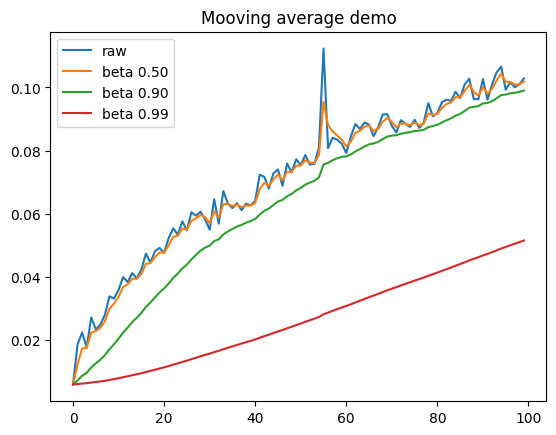

In [14]:
import matplotlib.pyplot as plt

timeseries_len = 100

outlier = torch.zeros(timeseries_len)
outlier[55] = 3

           # рандомный шум                   + квадратный корень                       + выброс
raw_data = torch.rand([timeseries_len]) + torch.sqrt(torch.arange(timeseries_len)) + outlier
raw_data = raw_data / 100

beta_values = torch.tensor([ 0.5, 0.9, 0.99 ])

mooving_avarages = torch.zeros([beta_values.shape[0], timeseries_len])
mooving_avarages[:, 0] = raw_data[0]

for i in range(1, timeseries_len):
    mooving_avarages[:, i] = mooving_avarages[:, i-1] * beta_values + (1-beta_values) * raw_data[i]

plt.plot(raw_data, label='raw')
for beta_i, beta in enumerate(beta_values.numpy().tolist()):
    plt.plot(mooving_avarages[beta_i, :], label=f"beta {beta:.2f}")

plt.legend()
plt.title("Mooving average demo")

## Demo optimizers

In [15]:
!nvidia-smi

Sat Feb  1 17:50:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
from torchvision.models import resnet18
import torch.optim as optim
import torch

resnet = resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [17]:
sum(p.numel() for p in resnet.parameters() if p.requires_grad) * 4 / 1024/1024

44.591949462890625

In [18]:
resnet = resnet.to('cuda')

In [19]:
!nvidia-smi

Sat Feb  1 17:50:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             26W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
adam = optim.Adam(resnet.parameters(), lr=3e-4)

out = resnet.forward(torch.rand(1, 3, 224, 224).to('cuda'))
loss = out.mean()
loss.backward()

adam.step()

In [21]:
!nvidia-smi

Sat Feb  1 17:50:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             27W /   70W |     406MiB /  15360MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### SGD

Потребляет меньше видеопамяти (ноль), тк не хранит статистики по градиентам


In [22]:
sgd = optim.SGD(resnet.parameters(), lr=3e-4)

out = resnet.forward(torch.rand(1, 3, 224, 224).to('cuda'))
loss = out.mean()
loss.backward()

sgd.step()

In [23]:
!nvidia-smi

Sat Feb  1 17:50:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             27W /   70W |     442MiB /  15360MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Регуляризация

In [24]:
import torch
import torch.nn as nn

## Dropout

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [25]:
dropout = nn.Dropout(p=0.5)
dropout.eval()
print(dropout.training) # важный флажок для дропаута - тк дропаут имеет разное поведение в процессе обучения и в процессе вычисления сети
dropout.train()
print(dropout.training)

dropout

False
True


Dropout(p=0.5, inplace=False)

In [26]:
list(dropout.parameters())

[]

In [27]:
t = torch.rand([3, 5], dtype=torch.float32)

print("t.mean()", t.mean().item())

t

t.mean() 0.49765947461128235


tensor([[0.3925, 0.5270, 0.4441, 0.3538, 0.8239],
        [0.1865, 0.1471, 0.8388, 0.6674, 0.9897],
        [0.4065, 0.7941, 0.1745, 0.6345, 0.0845]])

In [28]:
# Sequential( Linear(2, 16), Dropout(0.3) ) #  пример использования

In [29]:
# 1 / (1-p)

In [30]:
dropout.eval()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

assert torch.allclose(t_dropouted, t), "eval dropout doesn't change input tensor"

t_dropouted

t_dropouted.mean() 0.49765947461128235


tensor([[0.3925, 0.5270, 0.4441, 0.3538, 0.8239],
        [0.1865, 0.1471, 0.8388, 0.6674, 0.9897],
        [0.4065, 0.7941, 0.1745, 0.6345, 0.0845]])

In [31]:
dropout.train()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

print("zeros count", (t_dropouted == 0.0).sum().item(), "of", t_dropouted.numel())

t_dropouted

t_dropouted.mean() 0.5427606105804443
zeros count 8 of 15


tensor([[0.7850, 1.0541, 0.8882, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.6776, 0.0000, 1.9794],
        [0.0000, 1.5882, 0.0000, 0.0000, 0.1689]])

In [32]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout()

m = Model()
m.training

True

In [33]:
m = m.eval()
m.dropout.training

False

In [34]:
m = m.train()
m.dropout.training

True

## LabelSmoothing

In [35]:
nn.CrossEntropyLoss(label_smoothing=0.1)

CrossEntropyLoss()

**Несглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 1.0 |
| Hide The Pain Harold | 0.0 |
| That is fine  | 0.0 |
| Roll Safe Think About It | 0.0 |


**Сглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 0.91 |
| Hide The Pain Harold | 0.03 |
| That is fine  | 0.03 |
| Roll Safe Think About It | 0.03 |



## WeightDecay

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (..., weight_decay=0.1)

* [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

Stack Overflow: [AdamW and Adam with weight decay](https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay)

В чем разница:

* Adam + weight_decay --- регуляризация идет через градиенты
```
final_loss = loss + wd * all_weights.pow(2).sum() / 2
# backward ...
# optimizer.step:
w = w - lr * w.grad # grad contains regularisation
```

* AdamW --- регуляризация не идет через лосс
```
w = w - lr * w.grad - lr * wd * w
```


In [36]:
import torch.optim as optim

dummy_module_params = nn.Linear(1, 1).parameters()
adam = optim.Adam(dummy_module_params, weight_decay=0.01)

dummy_module_params = nn.Linear(1, 1).parameters()
adamw = optim.AdamW(dummy_module_params, weight_decay=0.1)

# Обновим Trainer и нашу модель


* Добавим поддержку lr_sheduler
* В модельку добавим дропаут

In [37]:
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [38]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

# ничего нового, копипаста с предыдущего сема
class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255


        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.62MB/s]


Extracting ./tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]


Extracting ./tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting ./tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.75MB/s]

Extracting ./tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



In [39]:
# Новый модуль
flatten_module = nn.Flatten(start_dim=1, end_dim=-1)
flatten_module(torch.rand([ 64, 28, 28 ])).shape

torch.Size([64, 784])

In [40]:
# Что добавилось:
# * `nn.Dropout`, и параметр `dropout_p` - новый слой и параметр в `__init__`
# * `nn.Flatten` - новый слой для схлопывания размерностей на входящих тензорах

class MLPModel(nn.Module):
    """
    Реализация MLP. Похожее мы уже видели на 1 и 2 семинаре.
    """

    def __init__(self, dropout_p=0.5, activation=None):
        """
        Инициализация модели.

        :param activation: Функция активации (по умолчанию ReLU).
        :param dropout_p: Процент зануляемых значений в активациях
        """
        super().__init__()

        if activation is None:
            activation = nn.ReLU()

        self.inner = nn.Sequential(
            # input ~ [ bs, 28, 28 ]
            nn.Flatten(), # ~ [ bs, 28 * 28 ]
            nn.Linear(784, 100),
            nn.Dropout(p=dropout_p),
            activation,
            nn.Linear(100, 10),
        )

        # nn.Sequential последовательно применяет переданные слои
        # self.linear_1 = nn.Linear(784, 100)
        # self.activation = nn.ReLU()
        # self.linear_2 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход данных через модель.

        :param x: Входные данные ~ [ bs, 784 ]
        :return: Выходные логиты модели ~ [ bs, 10 ]
        """
        return self.inner(x)

    def compute_all(self, batch):
        """
        Вычисляет лосс и точность по батчу данных.

        :param batch: Батч данных, содержащий 'sample' (входные данные) и 'label' (метки классов).
        :return: Значение функции потерь и словарь метрик.
        """

        x = batch['sample']    # [ bs, 784 ]
        y = batch['label']     # [ bs ] torch.LongTensor
        logits = self.inner(x) # [ bs, 10 ]

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = {
            "metrics/acc": acc,
            "metrics/loss": loss.detach().item(),
        }
        return loss, metrics


Checkout Trainer code diff https://www.diffchecker.com/4DoCByiU/


In [41]:
import wandb
wandb.login()
wandb.init(project="04_seminar_dropout_regularization")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mrsndmn (hsemrsndmn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [51]:
from typing import Iterable
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler

class Trainer:
    """
    Класс-абстракция для процесса обучения модели.
    Использует в себе все основные сущности:
        - модель
        - оптимизатор
        - Dataset
        - DataLoader
        -
    """
    def __init__(
            self,
            model: nn.Module,
            optimizer: Optimizer,
            train_dataset: Iterable,
            val_dataset: Iterable,
            lr_scheduler: LRScheduler=None,
            lr_scheduler_type: str=None,
            batch_size=128
        ):
        """
        Инициализация тренера.

        :param model: Обучаемая модель.
        :param optimizer: Оптимизатор.
        :param train_dataset: Датасет для обучения.
        :param val_dataset: Датасет для валидации.
        :param lr_scheduler: Объект класса `torch.optim.lr_scheduler.LRScheduler`
        :param lr_scheduler_type: Когда вызывать lr_scheduler: None, 'per_batch', 'per_epoch'
        :param batch_size: Размер батча.
        """

        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size


        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError(f"lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. Not: {lr_scheduler_type}")

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = wandb

    def log(self, log_data):

        self.writer.log(log_data, step=self.global_step)

        return

    def save_checkpoint(self, path: str):
        """
        Сохранение весов модели в указанный путь.

        :param path: Путь к файлу для сохранения.
        """
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):
        """
        Запуск процесса обучения модели.

        :param num_epochs: Количество эпох обучения.
        """

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)

        # валидационный датасет не стоит перемешивать
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in tqdm(range(num_epochs)):
            model.train()
            for batch in train_loader:
                self.training_step(batch)
                self.post_train_batch()
                self.global_step += 1

            # post triain hook
            self.post_train_stage()

            model.eval()

            val_losses = []
            for batch in val_loader:
                loss = self.validation_step(batch)
                val_losses.append(loss.item())
                self.post_val_batch()

            val_loss = np.mean(val_losses)
            self.log({ "validation/loss": val_loss })
            # Сохраняем только наилучшую модель
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

            # post val hook
            self.post_val_stage(val_loss)


    def training_step(self, batch):
        """
        Один шаг обучения: вычисление градиентов и обновление весов.

        :param batch: Батч данных для обучения.
        """
        self.optimizer.zero_grad()

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        loss.backward()
        self.optimizer.step()

        # Логирование метрик обучения
        log_metrics = { 'train/' + k: v for k, v in details.items() }
        log_metrics['train/loss'] = loss.item()

        self.log(log_metrics)

        return

    def validation_step(self, batch):
        """
        Один шаг валидации: вычисление ошибки на валидационных данных.

        :param batch: Батч данных для валидации.
        :return: Потери (loss) модели на текущем батче.
        """

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        return loss

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

            learning_rate = self.lr_scheduler.get_last_lr()[0]
            self.log({ "train/learning_rate": learning_rate})

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

        return



### Не забудь поменять Runtime Type в колабе на GPU!

In [43]:
import torch.utils.data

# берем часть исходной обучающей выборки для большей наглядности эффекта применения дропаута
# на большом датасете сложнее переобучиться, поэтому мы искусственно уменьшаем его для наглядности на занятии
# на практике не надо так делать!
fmnist_train_subset = torch.utils.data.Subset(fmnist_train, range(0, len(fmnist_train), 400))

### `dropout=0`

In [ ]:
model = MLPModel(dropout_p=0.)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val)

wandb.init(project="04_seminar_dropout_regularization", name="dropout=0.0", reinit=True)
trainer.train(30)

train/loss,█▇▇▆▆▅▄▄▄▄▄▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂
train/metrics/acc,▁▂▄▄▅▅▅▅▆▅▆▆▅▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▆▆█▇█▇▇▇▇▇█▇
train/metrics/loss,█▇▆▆▅▄▄▄▄▃▂▃▄▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
validation/loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.42716
train/metrics/acc,0.86364
train/metrics/loss,0.42716
validation/loss,0.8523


  0%|          | 0/30 [00:00<?, ?it/s]

### `dropout=0.3`

In [ ]:
model = MLPModel(dropout_p=0.3)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val)
wandb.init(project="04_seminar_dropout_regularization", name="dropout=0.3", reinit=True)
trainer.train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

### Wandb Screenshot

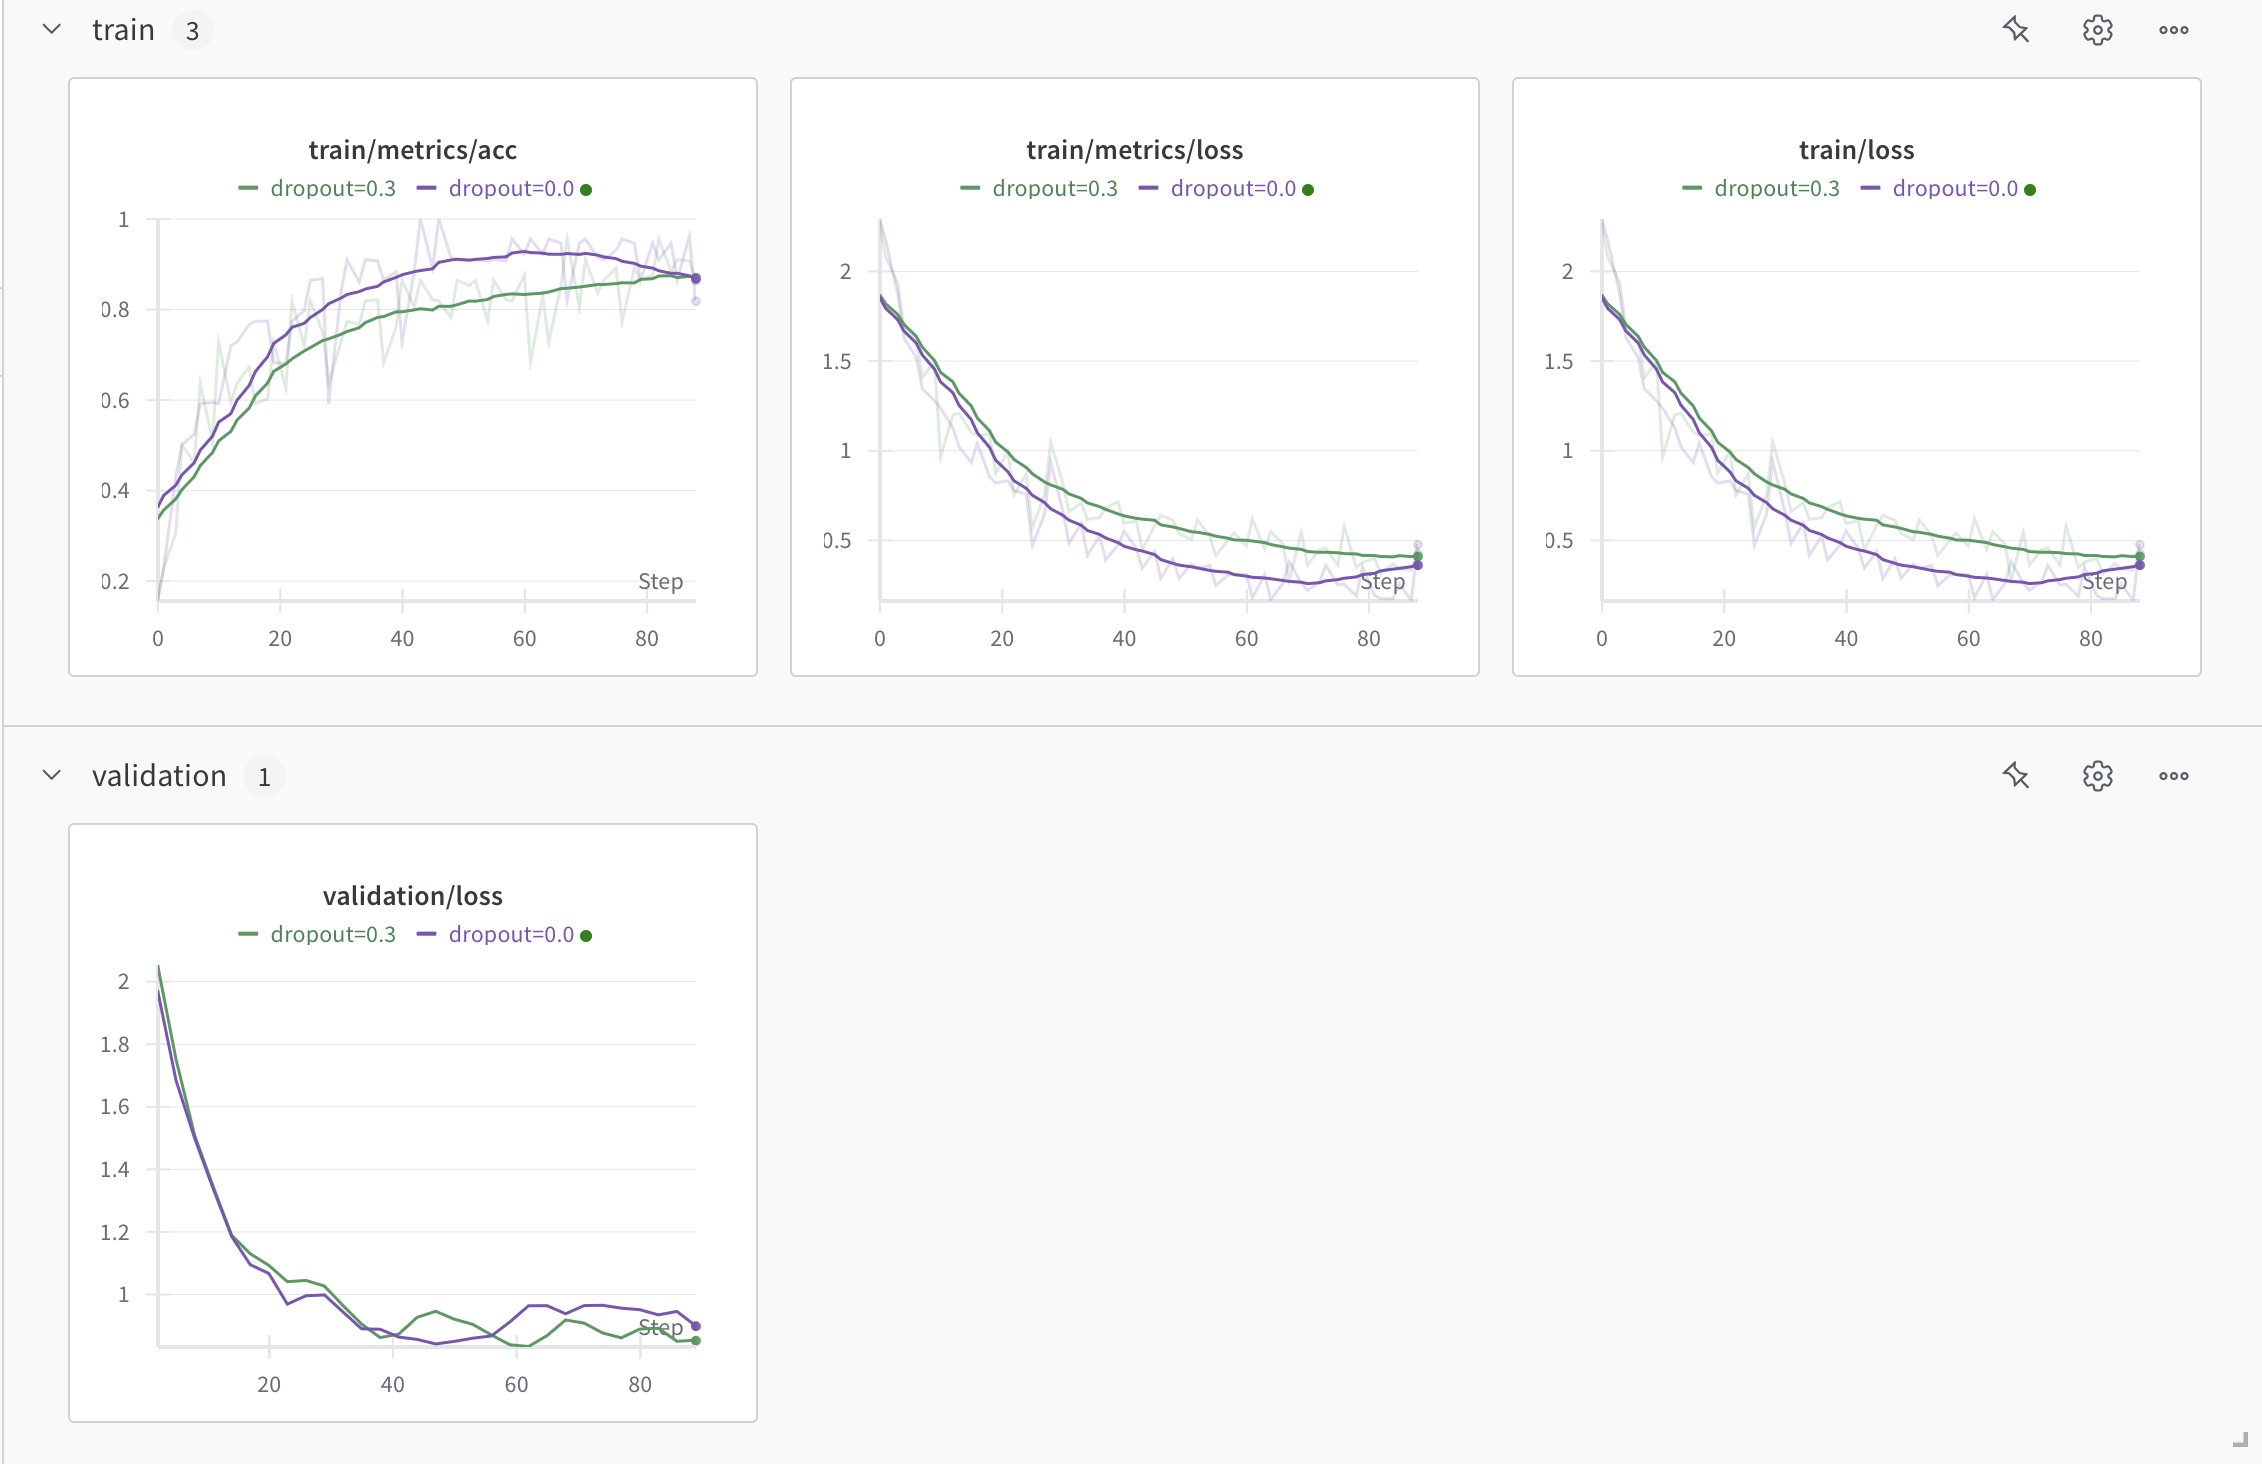

# LR Scheduler

Два типа расписаний:

- по эпохам ([StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), ...)
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам ([Cyclic](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html), [1cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

In [ ]:
def show_scheduler(scheduler, label=None):
    lr_history = []

    if label is None:
        label = str(scheduler)

    for i in range(100):
        lr_history.append(scheduler.get_last_lr()[0])
        scheduler.step()

    plt.plot(lr_history, label=label)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Text(0.5, 1.0, 'StepLR')

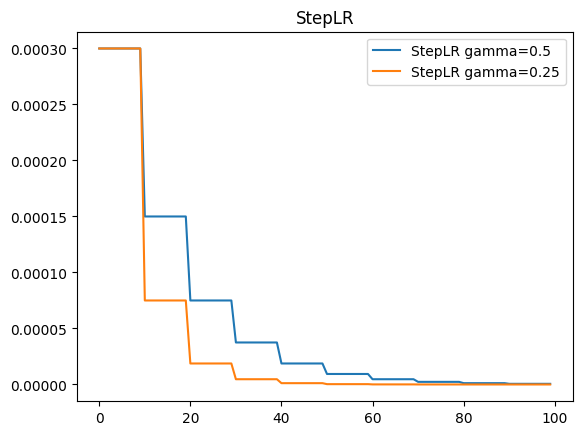

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5), label="StepLR gamma=0.5" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25), label="StepLR gamma=0.25" )

plt.legend()

plt.title("StepLR")

#### Пример обучения с использованием step lr
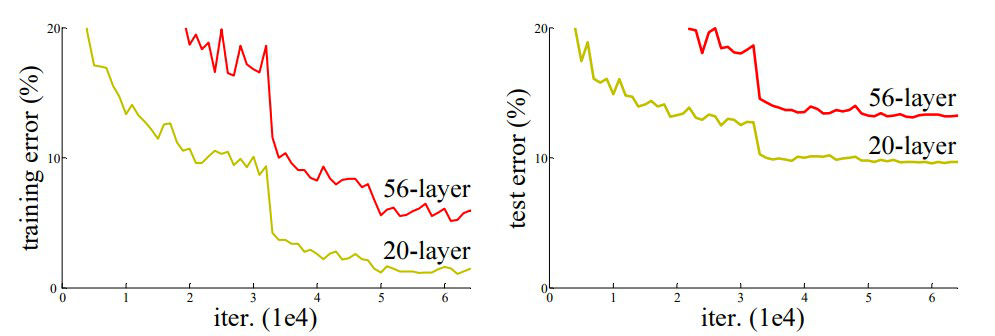

Text(0.5, 1.0, 'CyclicLR')

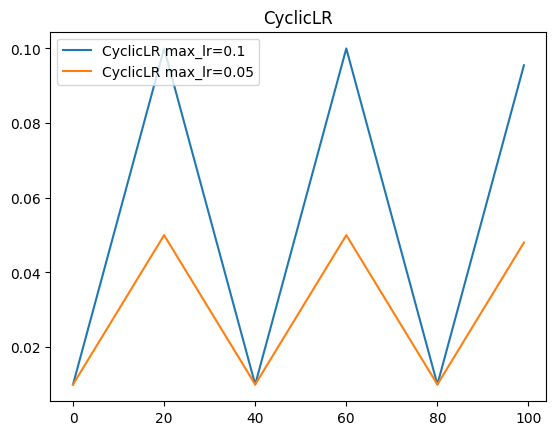

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.1" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.05" )

plt.legend()

plt.title("CyclicLR")

**Вопрос:** в каких случаях может быть полезен `CyclicLR`? Зачем повышать `lr`?

<!-- если во время оптимизации попали в локальный минимум, с увеличением lr можем выскочить из этого локального минимума и попасть в более глубокую 'лунку' -->

#### Обучим модельку с шедулером


In [56]:
model = MLPModel()

base_lr = 1e-3
max_lr = 0.005

optimizer = Adam(model.parameters(), lr=base_lr)
very_model_scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    step_size_up=10,
    cycle_momentum=False
)

wandb.init(project="04_seminar_dropout_regularization", name="CyclicLR", reinit=True)
trainer = Trainer(
    model,
    optimizer,
    fmnist_train_subset,
    fmnist_val,
    lr_scheduler=very_model_scheduler,
    lr_scheduler_type='per_batch'
)
trainer.train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

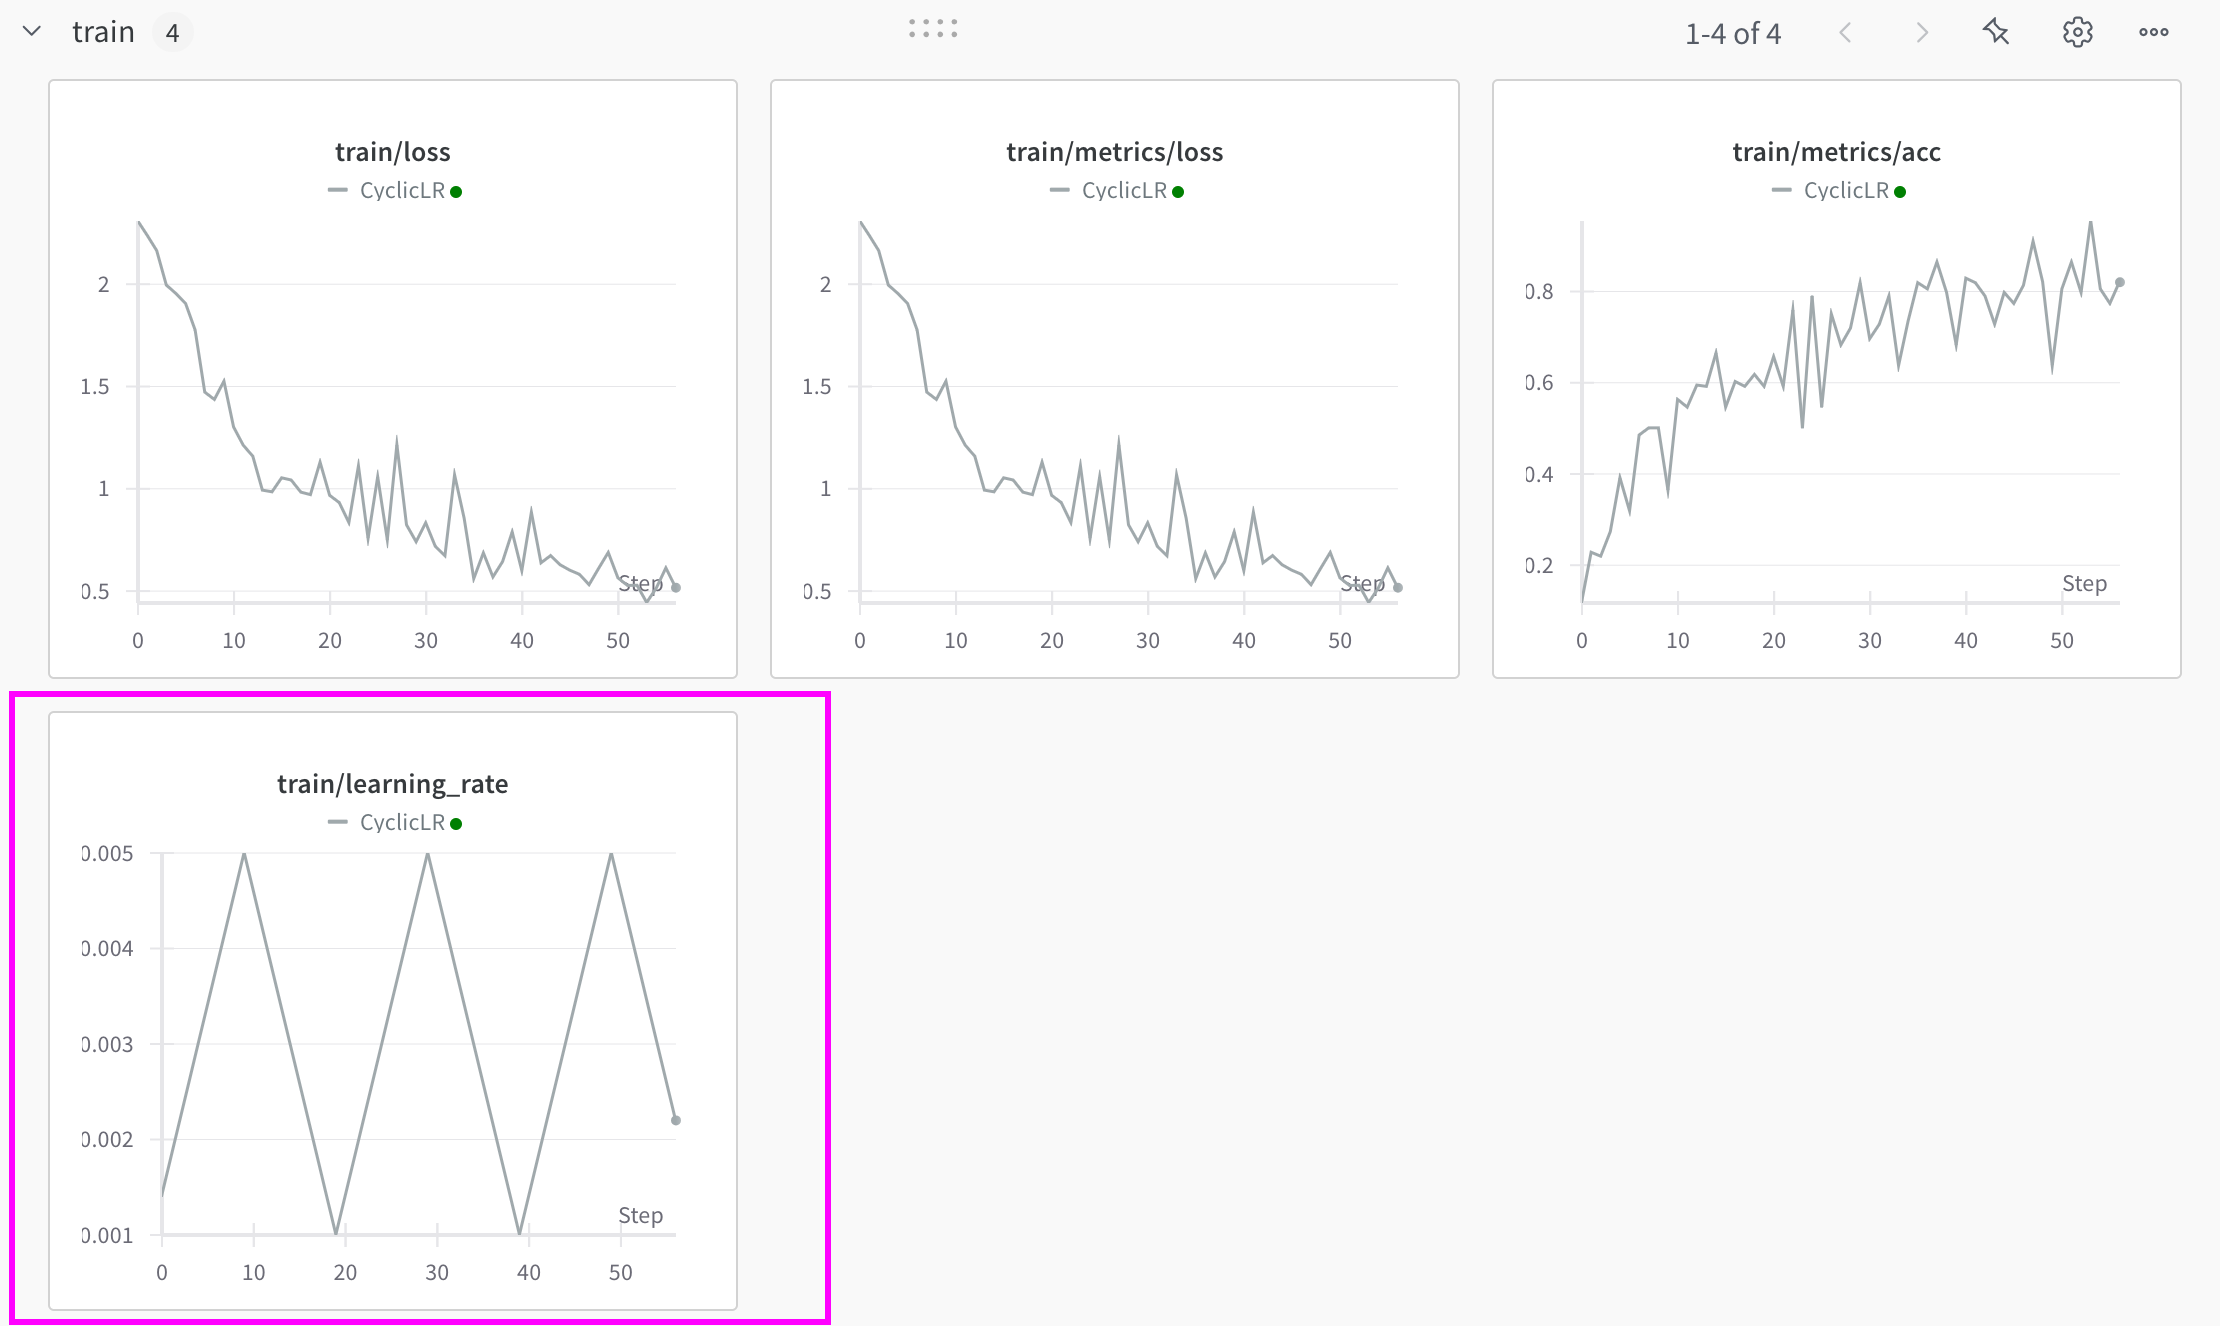

# WarmUp

**Проблема:** очень большие сетки может сильно разнести, если сразу начать их оптимизировать на больших батчах


Чтобы сеть не расходилась сразу, можно постепенно увеличивать lr --- тогда оптимизаторы постепенно накопят статистики по разным группам параметров

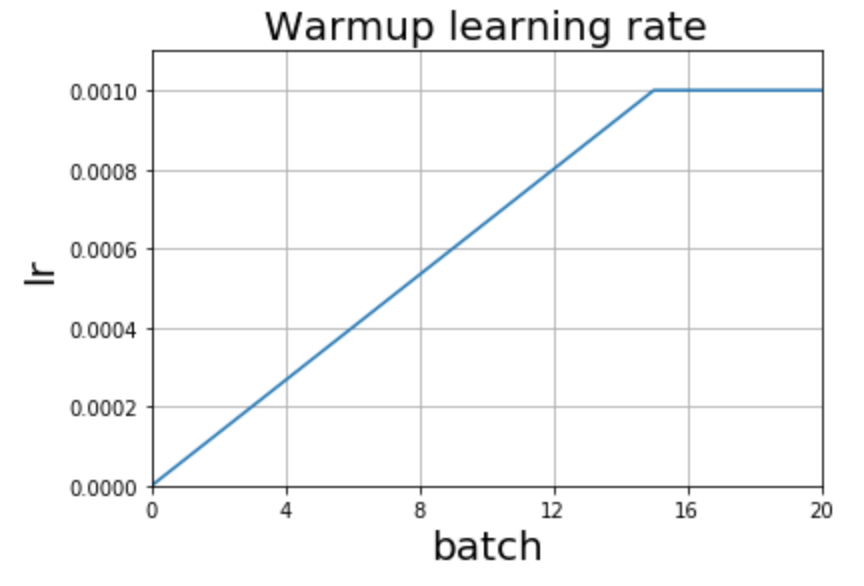


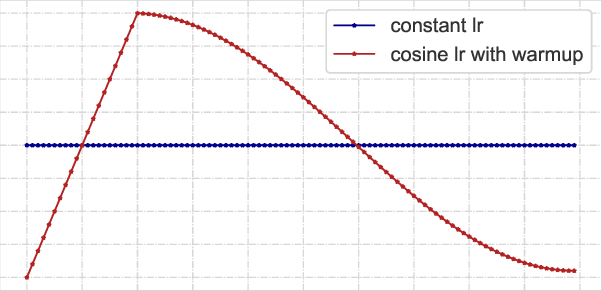

# Schedule Free Optimizers

## TODO

# Блиц по практике обучения нейросетей


### Может ли быть лосс отрицательным?

### Зачем нужен lr warmup?

<!---

Используется для обучения больших сетей для того, чтобы

-->

### Зачем нужен lr scheduling?

<!---

Чтобы получить лучшее качество модели или увеличить скорость обучения. Например, в начале обучения мы хотим побыстрее прийти к области с точкой оптимума. Но после того как мы к ней приблизились мы можем захотеть уменьшить lr для того, чтобы более точно подобрать значения параметров

--->



### Почему мы рассмотрели задачу об особенностях хранения чисел с плавующей точкой?

<!---

При маленьких значениях lr веса сети не будут обновляться из-за того, что операции с числаим с плавующей точкой имеют ограниченную точность

-->

### Как нужно изменить lr, если мы увеличили batch_size в 3 раза?

<!---

Для того, чтобы сохранить такую же скорость оптимизации LR нужно тоже увеличить в 3 раза.*

* Для определенной задачи, батч сайза


PS Хотя вообще говоря, это очень спорно. Можно придумать много граничных кейсов. Например, для простых задач может быть даже более эффективно обучаться на маленьком батчсайзе. Потому что чем меньше батч, тем быстрее вычисления и тем больше шагов оптимизации мы сможем сделать за единицу времени.

-->


### Как выбрать хорошие начальные значения для lr?

<!---

С помощью LR Finder'а

Строим зависимость Loss(learning_rate) и ищем точку перегиба. Диапозон неплохих lr будет начинаться в точке перегиба (возможно чуть левее), когда сеть начинает учиться, а заканчиваться до момента, когда лосс начинает шуметь, флуктуировать, колбасить

--->


### Как будет обучаться модель, если в нее добавить слой `nn.Dropout(p=1.0)`

<!-- Никак, потому что такой слой просто занулит тензор полностью -->

### Зачем внутри `Dropout` делается умножение на `1/(1-p)`? Что будет, если этого не сделать?

### Как изменяется поведение модуля `nn.Dropout` после того, как мы переключили модель в режим вычисления (`model.eval()`)?

<!-- Из доки торча: "During evaluation the module simply computes an identity function." -- лучше и не скажешь) https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html -->

### Для чего вообще нужен `nn.Dropout`?

<!-- Способ регуляризации, с дропаутом модели сложнее переобучиться на тренировочный датасет, улучшается обобщающая способность сети -->


### Мы хотим обучить модель на `1M` параметров с помощью `SGD` и с помощью `Adam`. Как изменится необходимый объем видеопамяти для обучения модели в зависимости от оптимизатора?

### Зачем `Adam` использует скользящее среднее для вычисления моментов?

### Зачем мы используем GPU для обучения/вычисления нейросетей?

### Нашел отзыв на яндекс маркете. Про какой это оптимизатор?

<!-- На самом деле, нельзя однозначно сказать. Это может быть как Adam, так и SGD с моментом или любой другой оптимизатор, которых хранит статистики по градиентам. -->

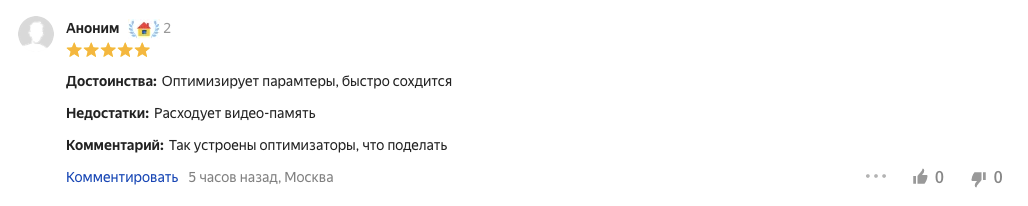

# Домашки:

* dropout
* optimization

In [ ]:
import torch
torch.max(torch.rand([3,3])-0.5, torch.zeros([3,3]))

tensor([[0.0000, 0.0000, 0.3764],
        [0.2160, 0.1474, 0.3432],
        [0.0000, 0.4576, 0.3718]])